The first set of features to drop made it worse apparently

In [2]:
from preprocess import surgery_preprocess # A .py with preprocessing code
# The models we'll use, minus XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score,train_test_split
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, f1_score, average_precision_score
import lightgbm as lgb

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# HyperOpt is a hyperparameter tuning package
from hyperopt import fmin, tpe, anneal, hp, Trials, space_eval
import numpy as np
from functools import partial

surgery=surgery_preprocess(split=False)

In [3]:
numeric_cols=['FVC', 'FEV1', 'Age', 'FEV1/FVC', 'FVC_deficit', 'FEV1_deficit',
       'FEV1/FVC_deficit', 'FEV1^2', 'FVC^2', 'Age*FVC', 'Age*FEV1',
       'FVC*FEV1', 'FVC^2*FEV1', 'FVC*FEV1^2']
def split(surgery, all_feat=True):
    X_train, X_test, y_train, y_test = train_test_split(surgery.drop('Risk1Yr', axis=1),
                                                        surgery['Risk1Yr'], 
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        stratify=surgery['Risk1Yr'],)
    ### Normalize numeric features ###
    scaler = StandardScaler()
    # Fit the test data in the same scale as the training data
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    ### Return the split train/test data ###
    return X_train, X_test, y_train, y_test

drop_1 = ['Pain','Weakness','Dyspnoea','Type2_diabetes',
                                     'FVC^2','FEV1^2']
drop_2 = ['Pain','Weakness','Dyspnoea','Type2_diabetes']
kf = StratifiedKFold(n_splits = 5, shuffle=True)
ros = RandomOverSampler()

In [14]:
# Idea for improvement: Make it so you can specify which scores to return
# and return them in a dict

def get_scores(pipe, train_X, test_X, train_y, test_y, scores, n=7):
    model_scores = {}
    for s in scores:
        model_scores[s] = 0

    for i in range(n):
        preds = pipe.predict(test_X)
        proba = pipe.predict_proba(test_X)[:,1]
        for s in scores:
            if s in ['roc_auc_score', 'average_precition_score']:
                model_scores[s] += eval(s+'(test_y, proba)')/n
            else:
                model_scores[s] += eval(s+'(test_y, preds)')/n
    
    return model_scores

In [74]:
import matplotlib.pyplot as plt
import matplotlib
def plot_scores(model_scores, scores=None):
    if scores == None:
        scores = list(model_scores.keys())
    if len(scores) > 5:
        nrow = len(scores)//2 - 1
        ncol = len(scores)//2 + len(scores)%2
    else:
        nrow = len(scores)//2 + len(scores)%2
        ncol = 2
    print(nrow, ncol)
    fig, ax = plt.subplots(nrow,ncol,figsize=(12,12))
    matplotlib.rc('xtick', labelsize=13) 
    matplotlib.rc('ytick', labelsize=13) 
    num = model_scores[scores[0]].shape[0]
    i = 0
    for s in scores:
        ax[i//ncol,i%ncol].bar(range(1,num+1), model_scores[s])
        ax[i//ncol,i%ncol].hlines(model_scores[s].mean(),1,num)
        ax[i//ncol,i%ncol].set_xlabel('Trial', size=14)
        ax[i//ncol,i%ncol].set_ylabel(s, size=14)
        #ax[i//2,i%2].set_title(names[i], size=14)
        i += 1

In [85]:
# Model should be the function to call, ie LogisticRegression,
# NOT LogisticRegression() - note the lack of parenthesis. Similarly,
# obj should be the objective function. Model args is a dict of hyperparameters
# that you may want to set manually for the chosen model
def build_model(model, params, obj, scores, k=8, n=10, evals=70, scoring='roc_auc',
                data=surgery, **model_args):
    scores_dict={}
    param_list=[]
    for s in scores:
        scores_dict[s] = np.zeros(k)
        
    for i in range(k):
        X_train, X_test, y_train, y_test = split(data)
        mod = model(**model_args)
        pipe = Pipeline([('upsample',ros),('model',mod)])
        trials = Trials()
        # Partial make its own callable function. When you call partial() you supply
        # a function with n args and supply k of them. Then, when you call the function
        # that partial creates, you supply the remaining n-k. These n-k serve as the
        # FIRST arguments to the function of which you made a partial
        fmin_func = partial(obj, pipe=pipe, train_X=X_train, train_y=y_train,
                            scoring=scoring)
        best = fmin(fn=fmin_func, 
                    space=params, algo=anneal.suggest, max_evals=evals,
                    trials=trials)
        best_params = space_eval(params,best)
        
        pipe.fit(X_train,y_train)
        pipe.set_params(**best_params)
        model_scores = get_scores(pipe, X_train, X_test, y_train, y_test,
                                    scores, n=n)
        for s in scores:
            scores_dict[s][i] = model_scores[s]
        param_list.append(best_params)
        
    return scores_dict, param_list

In [52]:
def lr_objective(params, pipe, train_X, train_y, scoring='roc_auc'):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring)
    return 1-score.mean()

scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']

lr_params = {'model__C': hp.uniform('model__C', 0,500)}

lr_args = {'max_iter': 2000,'C': 1.0000001}
lr_scores, lr_params = build_model(LogisticRegression, lr_params, 
                                   lr_objective, scores, k=4, n=6, evals=30,
                                   **lr_args)

 10%|████▊                                           | 3/30 [00:03<00:33,  1.24s/trial, best loss: 0.37056277056277054]


KeyboardInterrupt: 

In [77]:
lr_scores

{'roc_auc_score': array([0.69710669, 0.60940325, 0.60126582, 0.66184448]),
 'recall_score': array([0.71428571, 0.64285714, 0.5       , 0.64285714]),
 'accuracy_score': array([0.74193548, 0.62365591, 0.6344086 , 0.59139785]),
 'average_precision_score': array([0.28110599, 0.20211509, 0.17820999, 0.19151854])}

2 2


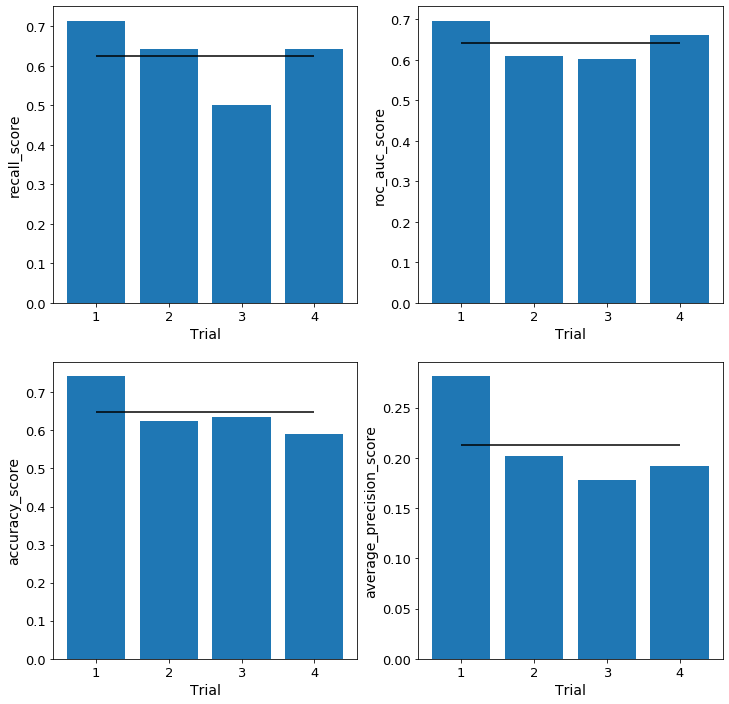

In [78]:
plot_scores(lr_scores, ['recall_score', 'roc_auc_score', 'accuracy_score', 'average_precision_score'])

Testing AUC varies A LOT based on the intial split

### LightGBM

In [87]:
import lightgbm as lgb

def lg_objective(params, pipe, train_X, train_y, scoring):
    pipe.set_params(**params)
    score = cross_val_score(pipe, train_X, train_y, cv=kf, scoring=scoring).mean()
    return 1-score

lg_params = {'model__n_estimators': hp.choice('model__n_estimators', range(15,80)),
             'model__learning_rate': hp.uniform('model__learning_rate',0.091,0.35),
             'model__max_depth': hp.choice('model__max_depth', range(3,9)),
             'model__bagging_fraction ': hp.uniform('model__subsample', 0.7, 1.0),
             'model__lambda': hp.uniform('model__lambda', 0.2,1.0)}

cat_feats = list(range(2,11))+list(range(23,27))

lg_args = {'metric': 'binary_logloss', 'categorical_features': cat_feats}
scores = ['roc_auc_score','recall_score', 'accuracy_score',
          'average_precision_score']


lg_scores, lg_params = build_model(lgb.LGBMClassifier, lg_params, lg_objective,
                                   scores, k=8, n=8, scoring='recall', **lg_args)

100%|████████████████████████████████████████████████| 70/70 [00:19<00:00,  3.68trial/s, best loss: 0.6363636363636364]


Mean roc_auc_score: 0.5472423146473779
Mean recall_score: 0.1607142857142857
Mean accuracy_score: 0.7231182795698925
Mean average_precision_score: 0.15641552966306457
2 2


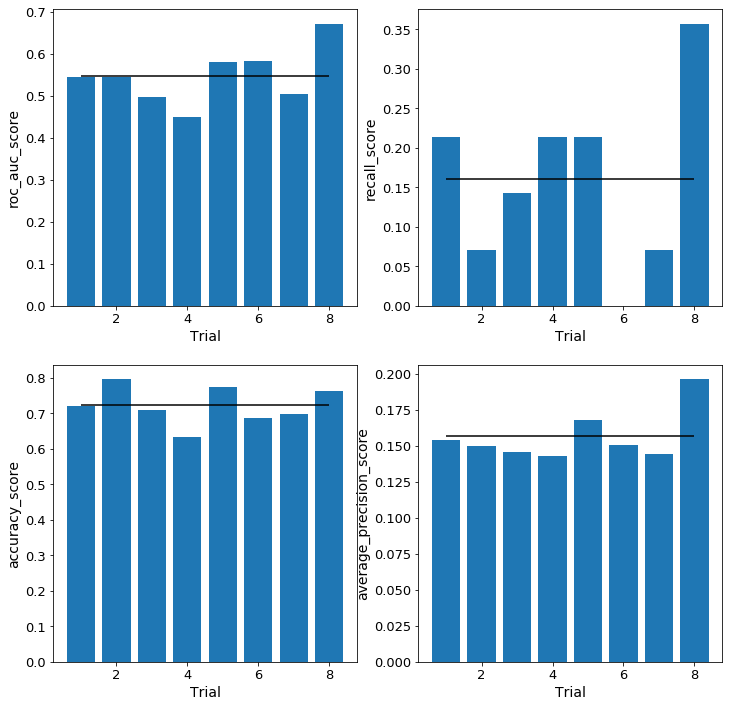

In [97]:
for k in lg_scores.keys():
    print(f'Mean {k}: {lg_scores[k].mean()}')
plot_scores(lg_scores)

In [124]:
dat

,num,proba,class
140,1,0.309460,0
62,2,0.226775,0
353,3,0.342474,0
114,4,0.277119,0
285,5,0.257511,0
...,...,...,...
413,89,0.613910,0
117,90,0.527613,0
230,91,0.243309,0
101,92,0.330484,0


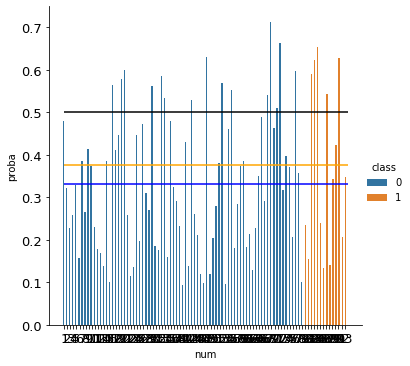

In [148]:
import seaborn as sns
import pandas as pd
lg_pipe = Pipeline([('upsample',ros),('model',lgb.LGBMClassifier(**lg_args))])
lg_pipe.set_params(**lg_params[np.argmax(lr_scores['roc_auc_score'])])
X_train, X_test, y_train, y_test = split(surgery)
lg_pipe.fit(X_train,y_train)
lg_proba = lg_pipe.predict_proba(X_test)[:,1]
dat = pd.DataFrame({'num':range(1,len(lg_proba)+1),
                    'proba': lg_proba,
                    'class': y_test})
dat.sort_values('class', inplace=True)
dat['num'] = range(1,len(lg_proba)+1)
dat.sort_values('num', inplace=True)
sns.catplot(x='num', y='proba', hue='class', kind='bar', data=dat)
plt.hlines(dat.loc[dat['class']==0,'proba'].mean(),0,93,colors='blue')
plt.hlines(dat.loc[dat['class']==1,'proba'].mean(),0,93,colors='orange')
plt.hlines(0.5,0,93,colors='black')